In [1]:

import source.preprocess as prep
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt


In [2]:

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2DTranspose, Layer, Lambda, Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, BatchNormalization, Activation, Reshape

from keras import backend as K
from keras.constraints import unit_norm, max_norm
from keras.losses import mse, binary_crossentropy
from keras.callbacks import Callback
from keras.layers.advanced_activations import LeakyReLU

In [3]:
def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(42)
    tf.random.set_seed(42)
    np.random.seed(42)
    random.seed(42)
    
reset_random_seeds()

## Prep data ..

In [4]:
    
# path to collect the sequence data    
main_path = 'C:/Users/npral/OneDrive/Desktop/AI+ProteinEngineering/Code/VAEforDesign/Inputs'    
SH3_path = main_path + '/sh3_59.fasta'

# read the sequence data
SH3_sequences = prep.get_seq(SH3_path)

# clean up data
sample, positions = len(SH3_sequences), len(SH3_sequences[0])
SH3_MSA = prep.create_MSA(SH3_sequences, sample, positions)

# pandas dataframe format
SH3_df = pd.DataFrame(SH3_MSA)
SH3_df.columns = ['Sequence']

In [5]:
def create_one_hot(df):
    """
    function description: create one hot encoded tensors
    
    """
    # We will use this dictionary to map each character to an integer so that it can be used as an input to our ML models:
    dict_int2aa = {0:"A",1:"C",2:"D",3:"E",4:"F",5:"G",6:"H",7:"I",8:"K",9:"L",10:"M",11:"N",12:"P",13:"Q",14:"R",15:"S",16:"T",17:"V",18:"W",19:"Y",20:"-"}

    token2int = {x:i for i, x in enumerate('ACDEFGHIKLMNPQRSTVWY-')}

    train_inputs = prep.preprocess_inputs(df, token2int)
    


    hot_inputs = np.zeros((train_inputs.shape[0], positions, 21))
    for sample in range(train_inputs.shape[0]):
        hot_encoded = prep.OneHot_encode(train_inputs, sample)
        #print(hot_inputs.shape, hot_encoded)
        hot_inputs[sample, :,:] = hot_encoded
        
    return hot_inputs

In [6]:
# create SH3 dataset into one hot encoded tensors: shape --> (datasize, protein_len, aa_labels)
SH3_onehot_inputs = create_one_hot(SH3_df)

In [7]:
"""
Load the relative enrichment values that correspond to the sequences
"""
main_path = 'C:/Users/npral/OneDrive/Desktop/AI+ProteinEngineering/Code/VAEforDesign/'
rel_path = main_path + 'Inputs/RE.npz'
rel_enrich = np.load(rel_path)['RE_mapping']


## Model assembly ..

In [8]:
def create_encoder(seq_len, aa_var, z_dim, intermediate_dim, alpha = 0.1):
    
    # Encoder comp ...
    encoder_input = Input(shape = (seq_len, aa_var))

    # flatten tensor into a vector
    x = Flatten()(encoder_input)
    
    x = Dense(intermediate_dim * 1.5, kernel_initializer = 'random_normal', )(x)
    x = LeakyReLU(alpha)(x)
    x = Dropout(0.3)(x)
    x = Dense(intermediate_dim * 1.5, kernel_initializer = 'random_normal', )(x)
    x = LeakyReLU(alpha)(x)
    x = Dense(intermediate_dim * 1.5, kernel_initializer = 'random_normal', )(x)
    x = LeakyReLU(alpha)(x)
    
    encoder_output = Dense(z_dim)(x)
    
    return Model(encoder_input, encoder_output, name = 'encoder'), encoder_input


def create_decoder(seq_len, aa_var, z_dim, intermediate_dim, alpha = 0.):

    decoder_input = Input(shape=(z_dim,), name='z_sampling')

    x = Dense(intermediate_dim*1.5, kernel_initializer='random_normal', )(decoder_input)
    x = LeakyReLU(alpha)(x)
    x = Dense(intermediate_dim*1.5, kernel_initializer='random_normal',)(x)
    x = LeakyReLU(alpha)(x)
    x = Dropout(0.7)(x)
    x = Dense(intermediate_dim*1.5,  kernel_initializer='random_normal',)(x)    
    x = LeakyReLU(alpha)(x)

    outputs = Dense(intermediate_dim, activation='linear', kernel_initializer='random_normal',)(x)                 
    outputs = Reshape((seq_len, aa_var))(outputs)
    softmax = tf.keras.activations.softmax(outputs, axis=-1)
    
    return Model(decoder_input, softmax, name = 'decoder') 

#MMD loss
def compute_kernel(x, y):
    
    x_size = K.shape(x)[0]
    y_size = K.shape(y)[0]
    dim = K.shape(x)[1]
    tiled_x = K.tile(K.reshape(x, [x_size, 1, dim]), [1, y_size, 1])
    tiled_y = K.tile(K.reshape(y, [1, y_size, dim]), [x_size, 1, 1])
    return K.exp(-K.mean(K.square(tiled_x - tiled_y), axis = 2) / K.cast(dim, 'float32'))

def compute_mmd(x, y):
    x_kernel = compute_kernel(x,x)
    y_kernel = compute_kernel(y,y)
    xy_kernel = compute_kernel(x,y)
    return K.mean(x_kernel) + K.mean(y_kernel) - 2 * K.mean(xy_kernel)

def mmdVAE_loss(train_z, train_xr, train_x):
    
    # sampling from the random noise ...
    batch_size = K.shape(train_z)[0]
    latent_dim = K.int_shape(train_z)[1]
    true_samples = K.random_normal(shape = (batch_size, latent_dim), mean = 0., stddev = 1.)
    
    # calc MMD loss
    loss_MMD = compute_mmd(true_samples, train_z)
    
    # calc the reconstruction loss (i.e. negative log-likelihood)
    loss_REC = K.mean(K.square(train_xr - train_x))

    return loss_REC + 2*loss_MMD




In [9]:
# hyperparameters ...

z_dim, alpha = 3, 0.1
samples, seq_len, aa_var = SH3_onehot_inputs.shape
input_dim = seq_len*aa_var # flatten input tensor
intermediate_dim = input_dim # scalar * intermediate_dim = hidden NN width


In [10]:
from sklearn.model_selection import KFold

def define_model(seq_len, aa_var, z_dim, intermediate_dim, alpha):
    # def model 
    encoder, encoder_input = create_encoder(seq_len, aa_var, z_dim, intermediate_dim, alpha)
    decoder = create_decoder(seq_len, aa_var, z_dim, intermediate_dim, alpha)

    # construct the complete MMD VAE model ...
    train_z = encoder(encoder_input)
    train_xr = decoder(train_z)
    MMD_VAE = Model(encoder_input, train_xr)

    #compile the whole model
    loss = mmdVAE_loss(train_z, train_xr, encoder_input)
    MMD_VAE.add_loss(loss)
    opt = tf.keras.optimizers.Adam(learning_rate= 0.000100023123)
    MMD_VAE.compile(optimizer = opt, metrics = ['MSE', 'categorical_crossentropy'])
    
    return MMD_VAE

In [11]:
encoder, encoder_input = create_encoder(seq_len, aa_var, z_dim, intermediate_dim, alpha)
decoder = create_decoder(seq_len, aa_var, z_dim, intermediate_dim, 0.1)


In [12]:
# construct the complete MMD VAE model ...
train_z = encoder(encoder_input)
train_xr = decoder(train_z)
MMD_VAE = Model(encoder_input, train_xr)


In [13]:
#compile the whole model
loss = mmdVAE_loss(train_z, train_xr, encoder_input)
MMD_VAE.add_loss(loss)
opt = tf.keras.optimizers.Adam(learning_rate= 0.000100023123)
MMD_VAE.compile(optimizer = opt, metrics = ['MSE', 'categorical_crossentropy'])
MMD_VAE.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 59, 21)]     0                                            
__________________________________________________________________________________________________
encoder (Functional)            (None, 3)            9217541     input_1[0][0]                    
__________________________________________________________________________________________________
decoder (Functional)            (None, 59, 21)       9218777     encoder[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Shape (TensorFlowOp [(2,)]               0           encoder[0][0]                    
_______________________________________________________________________________________

## Train model:

In [14]:
batch_size = 128
epochs = 1000


In [15]:
history = MMD_VAE.fit(SH3_onehot_inputs,
                      SH3_onehot_inputs,
                      epochs = epochs, 
                      batch_size = batch_size,
                      shuffle = True,
                      verbose = 2,
)

Epoch 1/1000
42/42 - 0s - loss: 0.1552 - MSE: 0.0427 - categorical_crossentropy: 2.7722
Epoch 2/1000
42/42 - 0s - loss: 0.0585 - MSE: 0.0371 - categorical_crossentropy: 2.2471
Epoch 3/1000
42/42 - 0s - loss: 0.0640 - MSE: 0.0362 - categorical_crossentropy: 2.1337
Epoch 4/1000
42/42 - 0s - loss: 0.0792 - MSE: 0.0356 - categorical_crossentropy: 2.0740
Epoch 5/1000
42/42 - 0s - loss: 0.0781 - MSE: 0.0351 - categorical_crossentropy: 2.0286
Epoch 6/1000
42/42 - 0s - loss: 0.0658 - MSE: 0.0346 - categorical_crossentropy: 1.9869
Epoch 7/1000
42/42 - 0s - loss: 0.0649 - MSE: 0.0342 - categorical_crossentropy: 1.9537
Epoch 8/1000
42/42 - 0s - loss: 0.0754 - MSE: 0.0340 - categorical_crossentropy: 1.9311
Epoch 9/1000
42/42 - 0s - loss: 0.0613 - MSE: 0.0337 - categorical_crossentropy: 1.9074
Epoch 10/1000
42/42 - 0s - loss: 0.0673 - MSE: 0.0336 - categorical_crossentropy: 1.8940
Epoch 11/1000
42/42 - 0s - loss: 0.0688 - MSE: 0.0334 - categorical_crossentropy: 1.8845
Epoch 12/1000
42/42 - 0s - los

42/42 - 0s - loss: 0.0412 - MSE: 0.0268 - categorical_crossentropy: 1.4950
Epoch 94/1000
42/42 - 0s - loss: 0.0420 - MSE: 0.0267 - categorical_crossentropy: 1.4959
Epoch 95/1000
42/42 - 0s - loss: 0.0481 - MSE: 0.0268 - categorical_crossentropy: 1.4968
Epoch 96/1000
42/42 - 0s - loss: 0.0447 - MSE: 0.0268 - categorical_crossentropy: 1.4965
Epoch 97/1000
42/42 - 0s - loss: 0.0446 - MSE: 0.0267 - categorical_crossentropy: 1.4917
Epoch 98/1000
42/42 - 0s - loss: 0.0420 - MSE: 0.0266 - categorical_crossentropy: 1.4869
Epoch 99/1000
42/42 - 0s - loss: 0.0433 - MSE: 0.0266 - categorical_crossentropy: 1.4873
Epoch 100/1000
42/42 - 0s - loss: 0.0451 - MSE: 0.0268 - categorical_crossentropy: 1.4945
Epoch 101/1000
42/42 - 0s - loss: 0.0445 - MSE: 0.0265 - categorical_crossentropy: 1.4819
Epoch 102/1000
42/42 - 0s - loss: 0.0424 - MSE: 0.0265 - categorical_crossentropy: 1.4837
Epoch 103/1000
42/42 - 0s - loss: 0.0462 - MSE: 0.0265 - categorical_crossentropy: 1.4841
Epoch 104/1000
42/42 - 0s - los

Epoch 185/1000
42/42 - 0s - loss: 0.0391 - MSE: 0.0249 - categorical_crossentropy: 1.4062
Epoch 186/1000
42/42 - 0s - loss: 0.0424 - MSE: 0.0251 - categorical_crossentropy: 1.4112
Epoch 187/1000
42/42 - 0s - loss: 0.0404 - MSE: 0.0250 - categorical_crossentropy: 1.4067
Epoch 188/1000
42/42 - 0s - loss: 0.0397 - MSE: 0.0249 - categorical_crossentropy: 1.4081
Epoch 189/1000
42/42 - 0s - loss: 0.0423 - MSE: 0.0250 - categorical_crossentropy: 1.4132
Epoch 190/1000
42/42 - 0s - loss: 0.0392 - MSE: 0.0250 - categorical_crossentropy: 1.4084
Epoch 191/1000
42/42 - 0s - loss: 0.0394 - MSE: 0.0249 - categorical_crossentropy: 1.4072
Epoch 192/1000
42/42 - 0s - loss: 0.0393 - MSE: 0.0249 - categorical_crossentropy: 1.4056
Epoch 193/1000
42/42 - 0s - loss: 0.0382 - MSE: 0.0249 - categorical_crossentropy: 1.4055
Epoch 194/1000
42/42 - 0s - loss: 0.0407 - MSE: 0.0250 - categorical_crossentropy: 1.4094
Epoch 195/1000
42/42 - 0s - loss: 0.0426 - MSE: 0.0249 - categorical_crossentropy: 1.4067
Epoch 196/

42/42 - 0s - loss: 0.0401 - MSE: 0.0241 - categorical_crossentropy: 1.3704
Epoch 277/1000
42/42 - 0s - loss: 0.0410 - MSE: 0.0243 - categorical_crossentropy: 1.3770
Epoch 278/1000
42/42 - 0s - loss: 0.0412 - MSE: 0.0241 - categorical_crossentropy: 1.3702
Epoch 279/1000
42/42 - 0s - loss: 0.0391 - MSE: 0.0241 - categorical_crossentropy: 1.3695
Epoch 280/1000
42/42 - 0s - loss: 0.0414 - MSE: 0.0240 - categorical_crossentropy: 1.3679
Epoch 281/1000
42/42 - 0s - loss: 0.0398 - MSE: 0.0241 - categorical_crossentropy: 1.3675
Epoch 282/1000
42/42 - 0s - loss: 0.0416 - MSE: 0.0242 - categorical_crossentropy: 1.3758
Epoch 283/1000
42/42 - 0s - loss: 0.0414 - MSE: 0.0241 - categorical_crossentropy: 1.3679
Epoch 284/1000
42/42 - 0s - loss: 0.0391 - MSE: 0.0241 - categorical_crossentropy: 1.3669
Epoch 285/1000
42/42 - 0s - loss: 0.0384 - MSE: 0.0240 - categorical_crossentropy: 1.3630
Epoch 286/1000
42/42 - 0s - loss: 0.0410 - MSE: 0.0241 - categorical_crossentropy: 1.3715
Epoch 287/1000
42/42 - 0s

Epoch 368/1000
42/42 - 0s - loss: 0.0388 - MSE: 0.0233 - categorical_crossentropy: 1.3343
Epoch 369/1000
42/42 - 0s - loss: 0.0384 - MSE: 0.0233 - categorical_crossentropy: 1.3369
Epoch 370/1000
42/42 - 0s - loss: 0.0375 - MSE: 0.0234 - categorical_crossentropy: 1.3384
Epoch 371/1000
42/42 - 0s - loss: 0.0389 - MSE: 0.0233 - categorical_crossentropy: 1.3383
Epoch 372/1000
42/42 - 0s - loss: 0.0387 - MSE: 0.0234 - categorical_crossentropy: 1.3393
Epoch 373/1000
42/42 - 0s - loss: 0.0399 - MSE: 0.0234 - categorical_crossentropy: 1.3414
Epoch 374/1000
42/42 - 0s - loss: 0.0368 - MSE: 0.0233 - categorical_crossentropy: 1.3386
Epoch 375/1000
42/42 - 0s - loss: 0.0385 - MSE: 0.0234 - categorical_crossentropy: 1.3382
Epoch 376/1000
42/42 - 0s - loss: 0.0381 - MSE: 0.0233 - categorical_crossentropy: 1.3346
Epoch 377/1000
42/42 - 0s - loss: 0.0384 - MSE: 0.0233 - categorical_crossentropy: 1.3395
Epoch 378/1000
42/42 - 0s - loss: 0.0385 - MSE: 0.0233 - categorical_crossentropy: 1.3344
Epoch 379/

42/42 - 0s - loss: 0.0370 - MSE: 0.0227 - categorical_crossentropy: 1.3123
Epoch 460/1000
42/42 - 0s - loss: 0.0385 - MSE: 0.0229 - categorical_crossentropy: 1.3215
Epoch 461/1000
42/42 - 0s - loss: 0.0362 - MSE: 0.0227 - categorical_crossentropy: 1.3131
Epoch 462/1000
42/42 - 0s - loss: 0.0370 - MSE: 0.0228 - categorical_crossentropy: 1.3165
Epoch 463/1000
42/42 - 0s - loss: 0.0372 - MSE: 0.0227 - categorical_crossentropy: 1.3143
Epoch 464/1000
42/42 - 0s - loss: 0.0394 - MSE: 0.0227 - categorical_crossentropy: 1.3133
Epoch 465/1000
42/42 - 0s - loss: 0.0391 - MSE: 0.0227 - categorical_crossentropy: 1.3128
Epoch 466/1000
42/42 - 0s - loss: 0.0379 - MSE: 0.0227 - categorical_crossentropy: 1.3131
Epoch 467/1000
42/42 - 0s - loss: 0.0375 - MSE: 0.0227 - categorical_crossentropy: 1.3152
Epoch 468/1000
42/42 - 0s - loss: 0.0389 - MSE: 0.0226 - categorical_crossentropy: 1.3087
Epoch 469/1000
42/42 - 0s - loss: 0.0385 - MSE: 0.0227 - categorical_crossentropy: 1.3128
Epoch 470/1000
42/42 - 0s

Epoch 551/1000
42/42 - 0s - loss: 0.0376 - MSE: 0.0220 - categorical_crossentropy: 1.2924
Epoch 552/1000
42/42 - 0s - loss: 0.0370 - MSE: 0.0221 - categorical_crossentropy: 1.2954
Epoch 553/1000
42/42 - 0s - loss: 0.0376 - MSE: 0.0221 - categorical_crossentropy: 1.2986
Epoch 554/1000
42/42 - 0s - loss: 0.0377 - MSE: 0.0221 - categorical_crossentropy: 1.2938
Epoch 555/1000
42/42 - 0s - loss: 0.0376 - MSE: 0.0221 - categorical_crossentropy: 1.2942
Epoch 556/1000
42/42 - 0s - loss: 0.0357 - MSE: 0.0221 - categorical_crossentropy: 1.2965
Epoch 557/1000
42/42 - 0s - loss: 0.0378 - MSE: 0.0222 - categorical_crossentropy: 1.2981
Epoch 558/1000
42/42 - 0s - loss: 0.0358 - MSE: 0.0222 - categorical_crossentropy: 1.2990
Epoch 559/1000
42/42 - 0s - loss: 0.0359 - MSE: 0.0220 - categorical_crossentropy: 1.2898
Epoch 560/1000
42/42 - 0s - loss: 0.0374 - MSE: 0.0220 - categorical_crossentropy: 1.2919
Epoch 561/1000
42/42 - 0s - loss: 0.0363 - MSE: 0.0220 - categorical_crossentropy: 1.2900
Epoch 562/

42/42 - 0s - loss: 0.0361 - MSE: 0.0216 - categorical_crossentropy: 1.2793
Epoch 643/1000
42/42 - 0s - loss: 0.0339 - MSE: 0.0215 - categorical_crossentropy: 1.2782
Epoch 644/1000
42/42 - 0s - loss: 0.0367 - MSE: 0.0217 - categorical_crossentropy: 1.2846
Epoch 645/1000
42/42 - 0s - loss: 0.0346 - MSE: 0.0216 - categorical_crossentropy: 1.2812
Epoch 646/1000
42/42 - 0s - loss: 0.0366 - MSE: 0.0216 - categorical_crossentropy: 1.2786
Epoch 647/1000
42/42 - 0s - loss: 0.0340 - MSE: 0.0216 - categorical_crossentropy: 1.2810
Epoch 648/1000
42/42 - 0s - loss: 0.0344 - MSE: 0.0215 - categorical_crossentropy: 1.2786
Epoch 649/1000
42/42 - 0s - loss: 0.0352 - MSE: 0.0215 - categorical_crossentropy: 1.2760
Epoch 650/1000
42/42 - 0s - loss: 0.0390 - MSE: 0.0215 - categorical_crossentropy: 1.2750
Epoch 651/1000
42/42 - 0s - loss: 0.0365 - MSE: 0.0215 - categorical_crossentropy: 1.2761
Epoch 652/1000
42/42 - 0s - loss: 0.0355 - MSE: 0.0215 - categorical_crossentropy: 1.2777
Epoch 653/1000
42/42 - 0s

Epoch 734/1000
42/42 - 0s - loss: 0.0362 - MSE: 0.0211 - categorical_crossentropy: 1.2699
Epoch 735/1000
42/42 - 0s - loss: 0.0363 - MSE: 0.0211 - categorical_crossentropy: 1.2688
Epoch 736/1000
42/42 - 0s - loss: 0.0342 - MSE: 0.0211 - categorical_crossentropy: 1.2693
Epoch 737/1000
42/42 - 0s - loss: 0.0341 - MSE: 0.0210 - categorical_crossentropy: 1.2647
Epoch 738/1000
42/42 - 0s - loss: 0.0365 - MSE: 0.0211 - categorical_crossentropy: 1.2680
Epoch 739/1000
42/42 - 0s - loss: 0.0376 - MSE: 0.0210 - categorical_crossentropy: 1.2674
Epoch 740/1000
42/42 - 0s - loss: 0.0347 - MSE: 0.0210 - categorical_crossentropy: 1.2661
Epoch 741/1000
42/42 - 0s - loss: 0.0370 - MSE: 0.0211 - categorical_crossentropy: 1.2684
Epoch 742/1000
42/42 - 0s - loss: 0.0364 - MSE: 0.0211 - categorical_crossentropy: 1.2688
Epoch 743/1000
42/42 - 0s - loss: 0.0362 - MSE: 0.0211 - categorical_crossentropy: 1.2688
Epoch 744/1000
42/42 - 0s - loss: 0.0361 - MSE: 0.0211 - categorical_crossentropy: 1.2667
Epoch 745/

42/42 - 0s - loss: 0.0352 - MSE: 0.0206 - categorical_crossentropy: 1.2566
Epoch 826/1000
42/42 - 0s - loss: 0.0323 - MSE: 0.0205 - categorical_crossentropy: 1.2574
Epoch 827/1000
42/42 - 0s - loss: 0.0326 - MSE: 0.0206 - categorical_crossentropy: 1.2600
Epoch 828/1000
42/42 - 0s - loss: 0.0326 - MSE: 0.0206 - categorical_crossentropy: 1.2606
Epoch 829/1000
42/42 - 0s - loss: 0.0341 - MSE: 0.0206 - categorical_crossentropy: 1.2597
Epoch 830/1000
42/42 - 0s - loss: 0.0348 - MSE: 0.0207 - categorical_crossentropy: 1.2594
Epoch 831/1000
42/42 - 0s - loss: 0.0344 - MSE: 0.0207 - categorical_crossentropy: 1.2600
Epoch 832/1000
42/42 - 0s - loss: 0.0339 - MSE: 0.0206 - categorical_crossentropy: 1.2591
Epoch 833/1000
42/42 - 0s - loss: 0.0340 - MSE: 0.0205 - categorical_crossentropy: 1.2560
Epoch 834/1000
42/42 - 0s - loss: 0.0372 - MSE: 0.0206 - categorical_crossentropy: 1.2617
Epoch 835/1000
42/42 - 0s - loss: 0.0329 - MSE: 0.0206 - categorical_crossentropy: 1.2543
Epoch 836/1000
42/42 - 0s

Epoch 917/1000
42/42 - 0s - loss: 0.0331 - MSE: 0.0203 - categorical_crossentropy: 1.2512
Epoch 918/1000
42/42 - 0s - loss: 0.0360 - MSE: 0.0202 - categorical_crossentropy: 1.2520
Epoch 919/1000
42/42 - 0s - loss: 0.0365 - MSE: 0.0203 - categorical_crossentropy: 1.2527
Epoch 920/1000
42/42 - 0s - loss: 0.0365 - MSE: 0.0203 - categorical_crossentropy: 1.2513
Epoch 921/1000
42/42 - 0s - loss: 0.0318 - MSE: 0.0203 - categorical_crossentropy: 1.2507
Epoch 922/1000
42/42 - 0s - loss: 0.0351 - MSE: 0.0202 - categorical_crossentropy: 1.2518
Epoch 923/1000
42/42 - 0s - loss: 0.0339 - MSE: 0.0203 - categorical_crossentropy: 1.2585
Epoch 924/1000
42/42 - 0s - loss: 0.0338 - MSE: 0.0202 - categorical_crossentropy: 1.2467
Epoch 925/1000
42/42 - 0s - loss: 0.0329 - MSE: 0.0201 - categorical_crossentropy: 1.2466
Epoch 926/1000
42/42 - 0s - loss: 0.0350 - MSE: 0.0201 - categorical_crossentropy: 1.2499
Epoch 927/1000
42/42 - 0s - loss: 0.0345 - MSE: 0.0203 - categorical_crossentropy: 1.2532
Epoch 928/

In [16]:
# sorting based on r.e scores 
re_sort_idx = np.argsort(
    rel_enrich, 
    axis = None
)

In [17]:
SH3_z_dim = encoder(SH3_onehot_inputs).numpy()

(array([  15.,  400., 2820., 1061.,   99.,   15.,   14.,   25.,   95.,
          27.]),
 array([-3.85100137, -3.44742478, -3.0438482 , -2.64027161, -2.23669503,
        -1.83311845, -1.42954186, -1.02596528, -0.62238869, -0.21881211,
         0.18476448]),
 <a list of 10 Patch objects>)

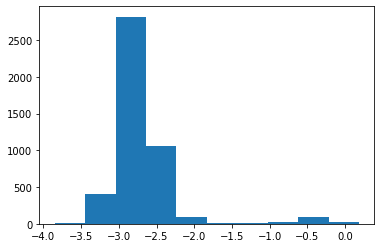

In [18]:
plt.hist(rel_enrich)

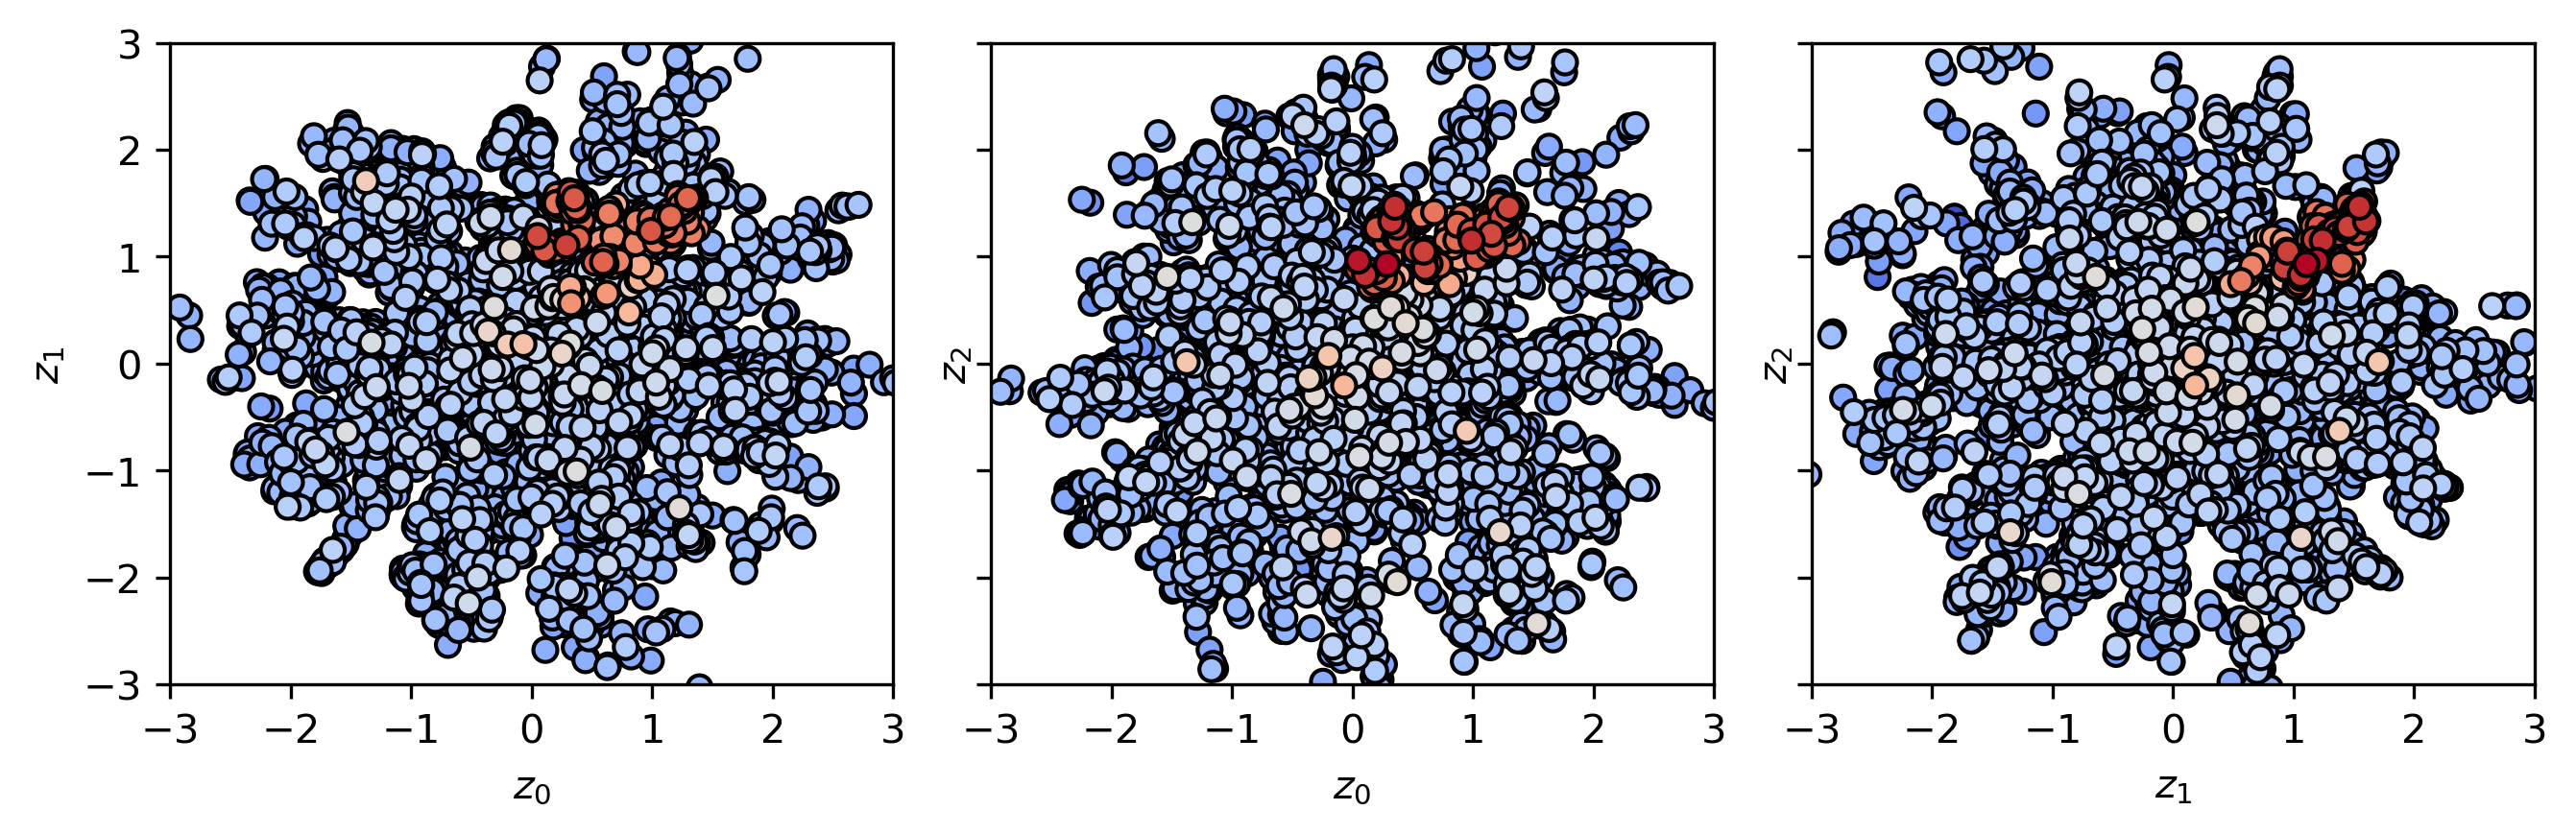

In [19]:

fig, axes = plt.subplots(1,3, figsize = (9,3), dpi = 300, sharex= True, sharey = True )


plot1 = axes[0].scatter(
    SH3_z_dim[re_sort_idx,0],
    SH3_z_dim[re_sort_idx,1],
    c = rel_enrich[re_sort_idx],
    cmap = 'coolwarm', 
    edgecolor = 'k'
)
plot2 = axes[1].scatter(
    SH3_z_dim[re_sort_idx,0],
    SH3_z_dim[re_sort_idx,2],
    c = rel_enrich[re_sort_idx],
    cmap = 'coolwarm',
    edgecolor = 'k'
)
plot3 = axes[2].scatter(
    SH3_z_dim[re_sort_idx,1],
    SH3_z_dim[re_sort_idx,2],
    c = rel_enrich[re_sort_idx],
    cmap = 'coolwarm',
    edgecolor = 'k'
)

axes[0].set_xlim([-3., 3.]) 
axes[0].set_ylim([-3., 3.])
plot1.set_clim([-4, 0.5])

axes[0].set_xlabel('$z_0$')
axes[0].set_ylabel('$z_1$')

axes[1].set_xlabel('$z_0$')
axes[1].set_ylabel('$z_2$')

axes[2].set_xlabel('$z_1$')
axes[2].set_ylabel('$z_2$')

plt.tight_layout()

## Plot phylogeny and paralogs:

In [20]:
nat_df = pd.read_excel('./data/LibraryNatural_Training5299.xls')

In [21]:
nat_df = nat_df.rename(columns = {'Sequence_aligned': 'Sequence'})

In [22]:
# one hot encoded for the natural df with annotated phylogeny
nat_x_OH = create_one_hot(nat_df)
nat_z = encoder(nat_x_OH).numpy()


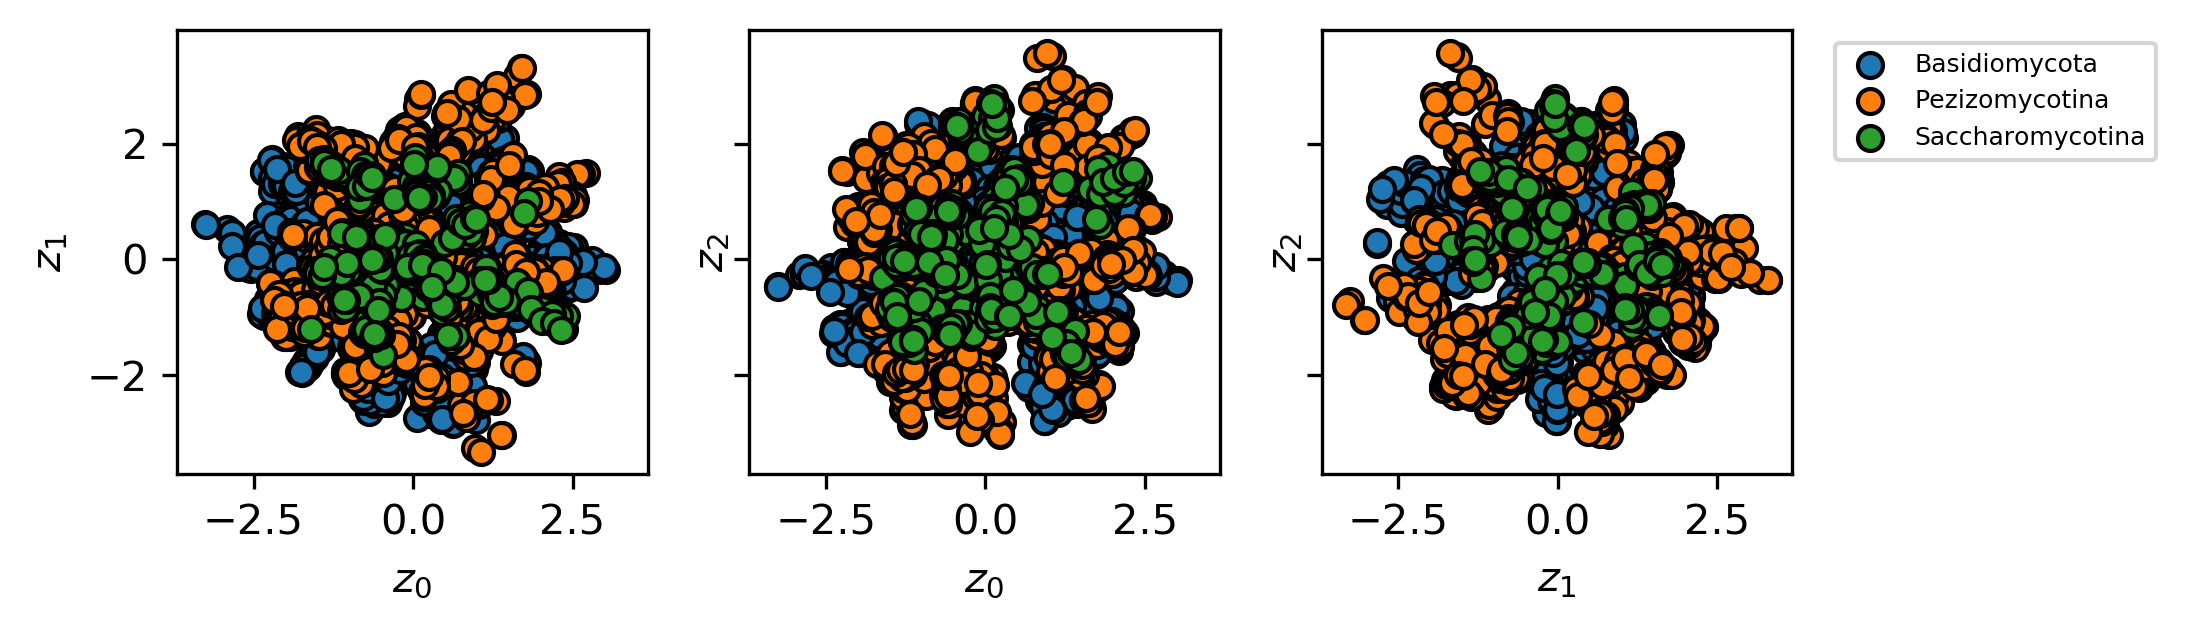

In [38]:
phylogeny = ['Saccharomycotina', 'Pezizomycotina', 'Basidiomycota']


fig, axes = plt.subplots(1,3, figsize = (7.5,2.2), dpi = 300, sharex= True, sharey = True )

for phylo in phylogeny[::-1]:

    phylo_z = nat_z[
    nat_df.Phylogeny.str.contains(phylo)
    ]

    
    axes[0].scatter(
    phylo_z[:,0],
    phylo_z[:,1],
    edgecolor = 'k',
    label  = phylo
    )
    
    axes[1].scatter(
    phylo_z[:,0],
    phylo_z[:,2],
    edgecolor = 'k',
    label  = phylo
    )
 

    axes[2].scatter(
    phylo_z[:,1],
    phylo_z[:,2],
    edgecolor = 'k',
    label  = phylo
    )
 
axes[0].set_xlabel('$z_0$')
axes[0].set_ylabel('$z_1$')

axes[1].set_xlabel('$z_0$')
axes[1].set_ylabel('$z_2$')

axes[2].set_xlabel('$z_1$')
axes[2].set_ylabel('$z_2$')

axes[2].legend(loc='upper right', bbox_to_anchor=(1.8, 1),fontsize=6)
plt.tight_layout()



In [24]:
sho1_z = nat_z[nat_df.orthologous_group == 'NOG09120']
bzz1_z = nat_z[
    (nat_df.orthologous_group == 'KOG3565_1') |
    (nat_df.orthologous_group == 'KOG3565_2') |
    (nat_df.orthologous_group == 'KOG3565_3') |
    (nat_df.orthologous_group == 'KOG3565_4') 
    ]
abp1_z = nat_z[nat_df.orthologous_group == 'KOG3655']
rvs167_z = nat_z[nat_df.orthologous_group == 'KOG3771']


In [25]:
sho1_re = nat_df.RE_norm[nat_df.orthologous_group == 'NOG09120']

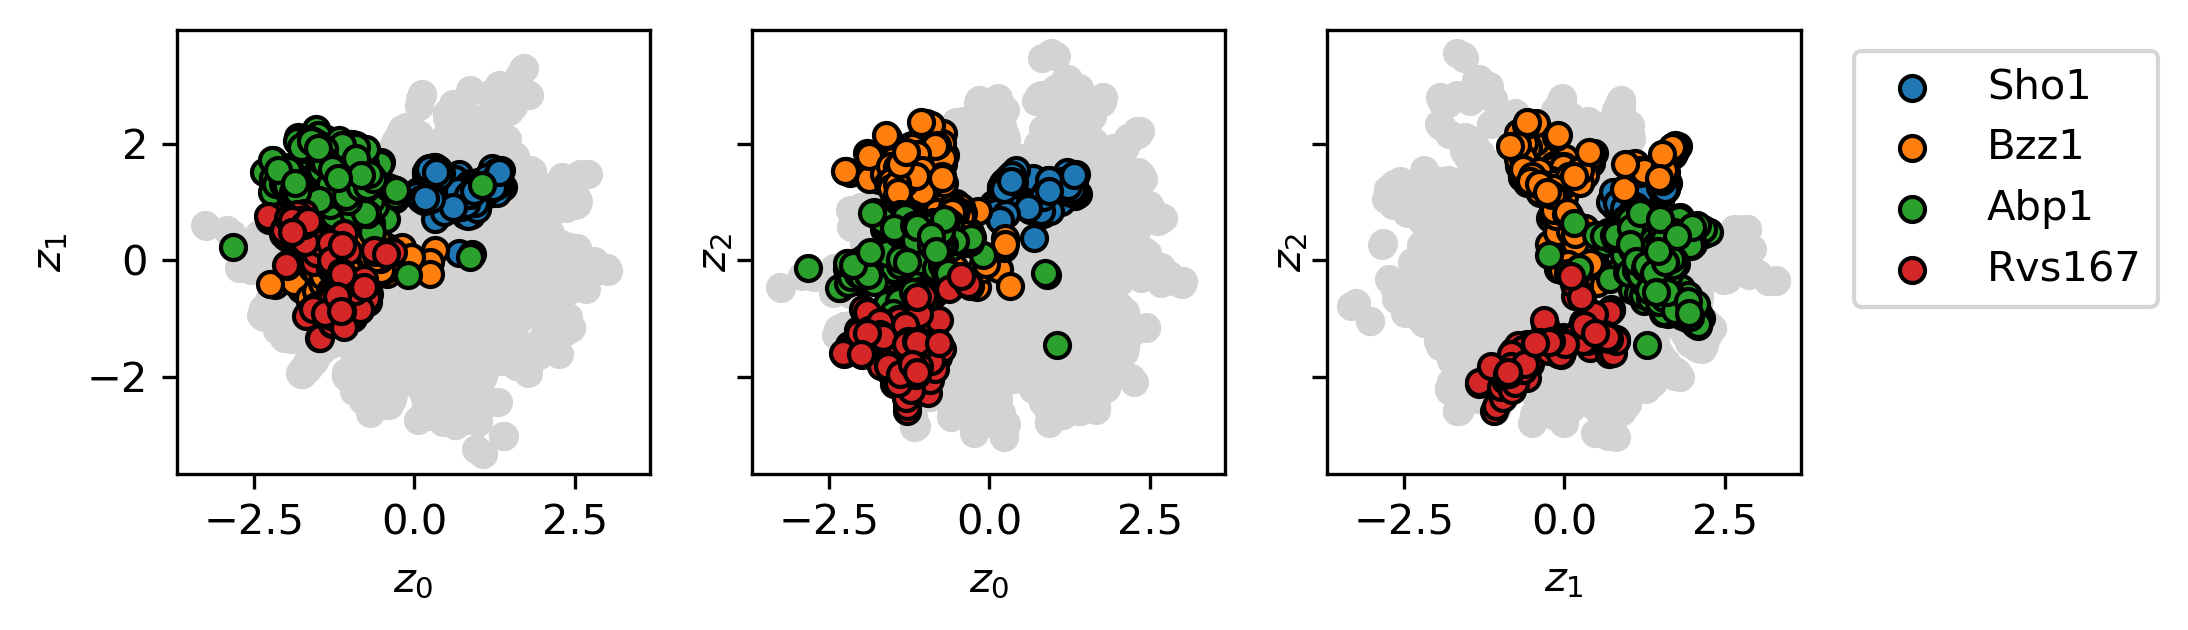

In [35]:

fig, axes = plt.subplots(1,3, figsize = (7.5,2.2), dpi = 300, sharex= True, sharey = True )


# first subplot
axes[0].scatter(
    nat_z[:,0],
    nat_z[:,1],
    color = 'lightgrey'
)
    
axes[0].scatter(
    sho1_z[:,0],
    sho1_z[:,1],
    edgecolor = 'k',
)

axes[0].scatter(
    bzz1_z[:,0],
    bzz1_z[:,1],
    edgecolor = 'k',
)

axes[0].scatter(
    abp1_z[:,0],
    abp1_z[:,1],
    edgecolor = 'k',
)

axes[0].scatter(
    rvs167_z[:,0],
    rvs167_z[:,1],
    edgecolor = 'k',
)


# second subplot

    
axes[1].scatter(
    nat_z[:,0],
    nat_z[:,2],
    color = 'lightgrey'
)
    
axes[1].scatter(
    sho1_z[:,0],
    sho1_z[:,2],
    edgecolor = 'k',
)

axes[1].scatter(
    bzz1_z[:,0],
    bzz1_z[:,2],
    edgecolor = 'k',
)

axes[1].scatter(
    abp1_z[:,0],
    abp1_z[:,2],
    edgecolor = 'k',
)

axes[1].scatter(
    rvs167_z[:,0],
    rvs167_z[:,2],
    edgecolor = 'k',
)



# third subplot

axes[2].scatter(
    nat_z[:,1],
    nat_z[:,2],
    color = 'lightgrey'
)
    
axes[2].scatter(
    sho1_z[:,1],
    sho1_z[:,2],
    edgecolor = 'k',
    label = 'Sho1'
)
axes[2].scatter(
    bzz1_z[:,1],
    bzz1_z[:,2],
    edgecolor = 'k',
    label = 'Bzz1'
)

axes[2].scatter(
    abp1_z[:,1],
    abp1_z[:,2],
    edgecolor = 'k',
    label = 'Abp1'
    
)

axes[2].scatter(
    rvs167_z[:,1],
    rvs167_z[:,2],
    edgecolor = 'k',
    label = 'Rvs167'
)




axes[0].set_xlabel('$z_0$')
axes[0].set_ylabel('$z_1$')

axes[1].set_xlabel('$z_0$')
axes[1].set_ylabel('$z_2$')

axes[2].set_xlabel('$z_1$')
axes[2].set_ylabel('$z_2$')

axes[2].legend(loc='upper right', bbox_to_anchor=(1.8, 1),fontsize=10)
plt.tight_layout()

